In [38]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import Data_Clean_Process as dc
import tn_helper as tn
# from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem, RBFSampler
# from sklearn import svm
from sklearn.svm import LinearSVC
%matplotlib inline


# Classifying Yelp Restaurants as Successful#

Yelp holds contests for students and the public where they release a large amount of data, and then have the particpants compete to reach one of a few specialized goals, ranging from building social network graphs to image recognition. We are using this data to tackle our own question, can we predict whether a restaurant has a good rating (four or five stars) or a bad rating (one, two or three stars). Because of the size of the dataset, we are storing it on a google cloud sql server, so our first step is to fetch only the data that we want.

## Data Processing ##
Once the data was on our sql server, we selected a subset of restaurants that we wanted to focus on and then looked at all of the reviews for each restaurant. We then computed some descriptive statistics about the review set for each restaurant to use as features in our classification model. The final list of features we used is listed at the end of this section, but some of the things we looked at were the review wordcounts and the engagement the reveiws received from other users. After creating those features on the sql server we then downloaded the data to python to set up the model.

In [2]:
business_data = dc.download_data()


Since our data cleaning was just formatting strings and filling in missing values without imputation, we clean before doing our train test split.

In [3]:
clean_data, numerical_features, categorical_features = dc.clean_data(
    business_data)


X_train, X_test, y_train, y_test = dc.tt_split(clean_data, numerical_features, categorical_features)


/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Pipelines ##
We set up piplines to use for hyperparameter tuning for all of the models that we used to classify our yelp restaurants. The first step is to make a column transformer that applies the correct preprocessing steps to each feature column in our data.

In [4]:
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(drop='first'), categorical_features)
)


Below we have the pipelines for the four models we tested, Logistic Regression, Random Forest, and two SVM methods.

### Logistic Regression ###

In [5]:
pipe_lr = Pipeline([('ct', preprocess),
                    ('clf', LogisticRegression())])

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': [.001, .01, .1, 1, 10, 100, 1000],
                   }]

log_results = pd.read_pickle('./CV_Results/Logistic_CV')


### Random Forest ###

In [13]:
pipe_rf = Pipeline([('scl', preprocess),
                    ('clf', RandomForestClassifier(oob_score=True, n_jobs=-1, verbose=1))])

grid_params_rf = [{'clf__criterion': ['gini'],
                   'clf__n_estimators': [300, 500],
                   'clf__min_samples_leaf': [10, 13, 15, 17],
                   'clf__max_depth': [20, 25, 30],
                   'clf__max_features': ['log2', 'sqrt']
                   }]

rf_results = pd.read_pickle('./CV_Results/Random_Forest_final_CV')


### SVM ###
Our two svm methods below use two different methods to approximate the radial kernel SVM using a linear SVC. One uses Nystroem method and the other uses a monte carlo method to approximate the radial kernel.

In [14]:
pipe_svm_ny = Pipeline([('ct', preprocess),
                        ("feature_map", Nystroem(gamma=.2)),
                        ('clf', LinearSVC(verbose=1, max_iter=15000, dual=False))])

grid_params_svm_ny = [{'feature_map__gamma': [.005, .01, .1],
                       'clf__C': [3000, 5000, 7000],
                       'clf__penalty': ['l1']
                       }]

svm_ny_results = pd.read_pickle('./CV_Results/SVM_Ny_RBF_CV')


In [15]:
pipe_svm_mc = Pipeline([('ct', preprocess),
                        ("feature_map", RBFSampler()),
                        ('clf', LinearSVC(verbose=1, max_iter=15000, dual=False))])

grid_params_svm_mc = [{'feature_map__gamma': [.005, .01, .02],
                       'clf__C': [1000, 2000, 3000],
                       'clf__penalty': ['l1']
                       }]

svm_mc_results = pd.read_pickle('./CV_Results/SVM_MC_RBF_3_CV')


## Hyperparamter Tuning ##

This executes the grid search over all the choices of parameters that have been specified in the pipeline. To run the search, set estimator to the pipline you want, set param_grid to the corresponding param grid dictionary, set cv to the number of crossvalidation steps, and set scoring equal to the scoring metric you would like to use in crossvalidation.Depending on the choice of model and hyperparameters this grid search may take a very long time to run, so we have left it commented out. Below we have summaries of the grid search results for each model. The full results of the grid searches are saved as pickled dataframes in the CV_Results folder.

In [16]:
# gridsearch = GridSearchCV(estimator=pipe,
#                           param_grid=grid_params_rf,
#                           scoring='accuracy',
#                           return_train_score=True,
#                           cv=5)

# gridsearch.fit(X_train, y_train)


Below we have a list of how the tuned versions of our models performed, with the list of hyper parameters, the mean cv test score and the mean fit time for the model.

In [17]:
results=[rf_results, svm_mc_results, svm_ny_results, log_results]

In [20]:
rf_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_feature_map__gamma,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,33.683355,17.456292,0.042153,0.003628,1000,l1,0.005,"{'clf__C': 1000, 'clf__penalty': 'l1', 'featur...",0.707738,0.718366,...,0.700055,0.710467,0.703932,0.708326,0.704892,0.710799,0.705594,0.709138,0.705534,0.003829
6,38.721678,12.128508,0.039485,0.001136,3000,l1,0.005,"{'clf__C': 3000, 'clf__penalty': 'l1', 'featur...",0.706410,0.706078,...,0.705594,0.703120,0.705557,0.705372,0.714270,0.703489,0.709692,0.708473,0.706675,0.003305
3,31.800397,9.157141,0.041192,0.003669,2000,l1,0.005,"{'clf__C': 2000, 'clf__penalty': 'l1', 'featur...",0.710727,0.709731,...,0.696548,0.711575,0.707513,0.703711,0.708067,0.701015,0.707772,0.705926,0.705294,0.003971
1,12.024139,3.900512,0.039627,0.000845,1000,l1,0.01,"{'clf__C': 1000, 'clf__penalty': 'l1', 'featur...",0.704749,0.715709,...,0.695957,0.704855,0.699723,0.709692,0.700277,0.699428,0.704301,0.702751,0.703016,0.003975
4,12.665459,2.950502,0.039856,0.002078,2000,l1,0.01,"{'clf__C': 2000, 'clf__penalty': 'l1', 'featur...",0.704417,0.704749,...,0.705077,0.699649,0.699834,0.698320,0.704892,0.705261,0.699797,0.699760,0.700852,0.002949


In [25]:
svm_mc_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_feature_map__gamma,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,33.683355,17.456292,0.042153,0.003628,1000,l1,0.005,"{'clf__C': 1000, 'clf__penalty': 'l1', 'featur...",0.707738,0.718366,...,0.700055,0.710467,0.703932,0.708326,0.704892,0.710799,0.705594,0.709138,0.705534,0.003829
6,38.721678,12.128508,0.039485,0.001136,3000,l1,0.005,"{'clf__C': 3000, 'clf__penalty': 'l1', 'featur...",0.706410,0.706078,...,0.705594,0.703120,0.705557,0.705372,0.714270,0.703489,0.709692,0.708473,0.706675,0.003305
3,31.800397,9.157141,0.041192,0.003669,2000,l1,0.005,"{'clf__C': 2000, 'clf__penalty': 'l1', 'featur...",0.710727,0.709731,...,0.696548,0.711575,0.707513,0.703711,0.708067,0.701015,0.707772,0.705926,0.705294,0.003971
1,12.024139,3.900512,0.039627,0.000845,1000,l1,0.01,"{'clf__C': 1000, 'clf__penalty': 'l1', 'featur...",0.704749,0.715709,...,0.695957,0.704855,0.699723,0.709692,0.700277,0.699428,0.704301,0.702751,0.703016,0.003975
4,12.665459,2.950502,0.039856,0.002078,2000,l1,0.01,"{'clf__C': 2000, 'clf__penalty': 'l1', 'featur...",0.704417,0.704749,...,0.705077,0.699649,0.699834,0.698320,0.704892,0.705261,0.699797,0.699760,0.700852,0.002949


In [26]:
svm_ny_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_feature_map__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,54.919311,14.741399,0.160517,0.022464,3000,l1,0.005,"{'clf__C': 3000, 'clf__penalty': 'l1', 'featur...",0.716208,0.713488,0.710996,0.713564,0.002129,1,0.713040,0.719882,0.717141,0.716688,0.002812
1,16.841730,2.294656,0.147986,0.011421,3000,l1,0.01,"{'clf__C': 3000, 'clf__penalty': 'l1', 'featur...",0.718900,0.713887,0.706211,0.712999,0.005218,2,0.717127,0.721079,0.717141,0.718449,0.001860
6,41.527374,18.797767,0.134832,0.003175,7000,l1,0.005,"{'clf__C': 7000, 'clf__penalty': 'l1', 'featur...",0.717604,0.713089,0.708105,0.712933,0.003879,3,0.718373,0.720082,0.716393,0.718283,0.001507
7,15.886728,1.772875,0.140170,0.011290,7000,l1,0.01,"{'clf__C': 7000, 'clf__penalty': 'l1', 'featur...",0.714414,0.711893,0.710996,0.712434,0.001447,4,0.713688,0.714848,0.719683,0.716073,0.002596
4,15.520593,3.301066,0.137980,0.004638,5000,l1,0.01,"{'clf__C': 5000, 'clf__penalty': 'l1', 'featur...",0.717604,0.709999,0.709301,0.712301,0.003760,5,0.714435,0.714749,0.717440,0.715541,0.001349


In [27]:
log_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,4.600864,0.663783,0.083258,0.018498,1,l1,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.712791,0.712791,0.709870,...,0.709743,0.003373,1,0.711307,0.709105,0.710500,0.711497,0.714072,0.711296,0.001624
7,1.156987,0.197045,0.076376,0.009131,1,l2,"{'clf__C': 1, 'clf__penalty': 'l2'}",0.712957,0.712126,0.708873,...,0.709377,0.003362,2,0.710974,0.709354,0.710334,0.711206,0.713241,0.711022,0.001282
8,11.642853,2.640865,0.086677,0.014818,10,l1,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.712791,0.712292,0.709704,...,0.709377,0.003531,2,0.710601,0.709894,0.710292,0.711123,0.713823,0.711147,0.001397
9,1.237897,0.148014,0.078383,0.011968,10,l2,"{'clf__C': 10, 'clf__penalty': 'l2'}",0.713123,0.711794,0.709538,...,0.709377,0.003342,2,0.710891,0.709811,0.710251,0.711123,0.713823,0.711180,0.001401
13,3.142221,0.947283,0.104491,0.035670,1000,l2,"{'clf__C': 1000, 'clf__penalty': 'l2'}",0.711960,0.711960,0.710037,...,0.709377,0.003217,2,0.711224,0.709728,0.710375,0.710251,0.713906,0.711097,0.001484


In [28]:
pd.options.display.max_colwidth=150
tn.top_models(results)

,params,mean_test_score,std_test_score,mean_fit_time
rf_results,"{'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 300}",0.717585,0.003375,6.973171
svm_mc_results,"{'clf__C': 1000, 'clf__penalty': 'l1', 'feature_map__gamma': 0.005}",0.704559,0.008361,33.683355
svm_ny_results,"{'clf__C': 3000, 'clf__penalty': 'l1', 'feature_map__gamma': 0.005}",0.713564,0.002129,54.919311
log_results,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.709743,0.003373,4.600864


As you can see, the Random Forest model performed the best, but after tuning all of the models performed similarly in terms of accuracy. We decided to use Random forest as our model not only because it had the best performance, but because it had the second fastest mean fit time.

## Looking at the Model ##

In [39]:
random_forest = RandomForestClassifier(
    max_depth=30, max_features='sqrt', min_samples_leaf=10, n_estimators=300, n_jobs=-1,oob_score=True)

t_X_train=preprocess.fit_transform(X_train)
t_X_test=preprocess.fit_transform(X_test)

random_forest.fit(t_X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

Now we run our final model on all of the testing data, and then verify it against the testing data.

In [40]:
# training accuracy
random_forest.score(t_X_train,y_train)

0.8340200704459361

In [41]:
# testing accuracy
random_forest.score(t_X_test,y_test)

0.7139819245082403

In [42]:
# cm=ConfusionMatrix(random_forest)
# cm.poof()


The test score for our model on data that has not been used for hyperparameter tuning agrees with our crossvalidation results, so we can be pretty confident in the ability of our model to classify unseen data.

### Important Features ###

In [44]:
# importances=random_forest.feature_importances_
# ohe=OneHotEncoder(drop='first').fit(X_test[categorical_features])
# categorical_names=ohe.get_feature_names()
# feature_names=numerical_features+list(categorical_names)
# importances_df=pd.concat([pd.DataFrame(importances),pd.DataFrame(feature_names)],axis=1)
# importances_df.columns=['Importance','Feature']
# importances_df.sort_values(by='Importance',ascending=False).head(10)
importances_df=feature_importance(random_forest, X_train, categorical_features)
importances_df.head(10)

NameError: name 'importances_df' is not defined

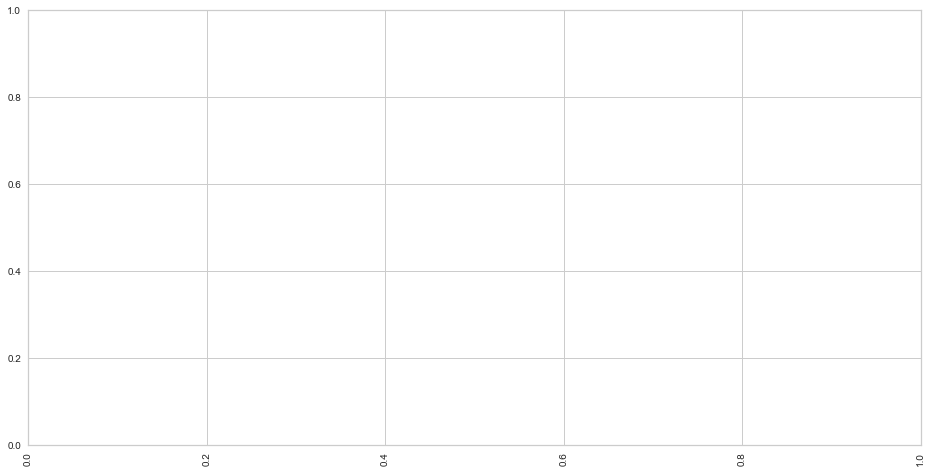

In [45]:
plt.figure(figsize=(16, 8))
plt.xticks(rotation='vertical')
plt.bar(x=importances_df.Feature, height=importances_df.Importance)
plt.savefig('features.png',)


In [ ]:
categorical_features[22],categorical_features[24]